![hybrid.jpg](https://github.com/ML-Response-Unit/recsys_pipes/blob/main/research/hybrid.jpg?raw=1)

In [87]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [195]:
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import Birch
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.metrics import accuracy_score


In [89]:
user_data = pd.read_csv("../data/customers.csv").dropna()
actions_data = pd.read_csv("../data/dataset.csv").dropna().astype(int)
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

## Preprocess user data

In [90]:
user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,Male,No,22,No,Healthcare,4.0
1,817,Female,Yes,38,Yes,Engineer,3.0
2,495,Female,Yes,67,Yes,Engineer,1.0
3,36,Male,Yes,67,Yes,Lawyer,2.0
4,76,Female,Yes,40,Yes,Entertainment,6.0
...,...,...,...,...,...,...,...
315,353,Male,Yes,74,Yes,Lawyer,2.0
316,411,Female,No,30,No,Homemaker,4.0
317,297,Female,No,37,Yes,Artist,2.0
318,186,Female,No,22,No,Marketing,1.0


In [91]:
# Identify the categorical columns
cat_cols = ['gender', 'married', 'graduated', 'profession']

# Convert the categorical columns to numerical using Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    user_data[col] = le.fit_transform(user_data[col])

user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,1,0,22,0,5,4.0
1,817,0,1,38,1,2,3.0
2,495,0,1,67,1,2,1.0
3,36,1,1,67,1,7,2.0
4,76,0,1,40,1,3,6.0
...,...,...,...,...,...,...,...
315,353,1,1,74,1,7,2.0
316,411,0,0,30,0,6,4.0
317,297,0,0,37,1,0,2.0
318,186,0,0,22,0,8,1.0


## Preprocess cars data

In [92]:
cars_data = pd.read_csv("../data/cars_about.csv").dropna()

cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
# Identify the categorical columns
car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

# Convert the categorical columns to numerical using Label Encoding
for col in car_cat_cols:
    le = LabelEncoder()
    cars_data[col] = le.fit_transform(cars_data[col])

cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


## Preprocess actions data

In [93]:
actions_data = actions_data.rename(columns = {"item_id":"car_id"})

In [94]:
actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [95]:
actions_data.car_id.nunique()

109

In [96]:
px.imshow(actions_pivot_table)

In [97]:
actions_data = pd.melt(actions_pivot_table.reset_index(), id_vars='user_id', value_vars=actions_pivot_table.columns).rename(columns={"value":"interaction"})

In [98]:
actions_data.interaction.unique()

array([1, 0])

In [99]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [100]:
actions_data.interaction = actions_data.interaction.apply(lambda a: 1 if a > 0.5 else 0)

In [101]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [102]:
new_actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [103]:
px.imshow(new_actions_pivot_table)

## CatBoost inputs

1. собираю фичи топ n понравившихся авто
2. конкатенирую фичи понравившихся авто с таргет авто
3. делаю бинарную классификацию 

In [104]:
N_POSITIVE = 5

In [105]:
column_names = []
cat_columns = ['used_label', 'exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']
cat_features = []

for index in range(N_POSITIVE):
    for column in cars_data.columns:
        column_names.append(f"car_{index}_{column}")
        
for column in cars_data.columns:
    column_names.append(f"target_{column}")

for column in column_names:
    for c_column in cat_columns:
        if c_column in column:
            cat_features.append(column)
        
dataset = pd.DataFrame(columns=column_names + ["interaction"])

for user_id in actions_data.user_id.unique():
    for target_car_id in actions_data.car_id.unique():
        # len(cars_data.columns) * (N_POSITIVE + 1))
        matrix_features = []
        features = []
        current_positive_samples = actions_data.query(f"user_id == {user_id}").query(f"car_id != {target_car_id}").query("interaction == 1")
        # print()
        if len(current_positive_samples) < N_POSITIVE: continue

        for car_id in current_positive_samples.sample(N_POSITIVE).car_id.to_list():
            matrix_features.append(cars_data.iloc[car_id].to_list())
        matrix_features.append(cars_data.iloc[target_car_id].to_list())
        matrix_features.append(int(actions_data.loc[actions_data.car_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        for item in matrix_features:
            if isinstance(item, list):
                for elem in item:
                    features.append(elem)
            else:
                features.append(item)
        # print(features)
        dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])

# dataset = dataset.astype(int)

In [106]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,25.0,180.0,83.0,5.0,15.0,22.0,0.0,9.0,135228.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [107]:
dataset.shape

(6931, 67)

In [108]:
dataset.interaction.value_counts()

0    6438
1     493
Name: interaction, dtype: int64

In [109]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,25.0,180.0,83.0,5.0,15.0,22.0,0.0,9.0,135228.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,51.0,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [110]:
balanced_dataset = pd.concat([dataset.loc[dataset.interaction == 1], dataset.loc[dataset.interaction == 0].sample(int(dataset.interaction.value_counts()[1] * 1.5))])

In [111]:
balanced_dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,22.0,1
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,8.0,1
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,25.0,180.0,83.0,5.0,15.0,22.0,0.0,9.0,135228.0,...,64.0,52.0,2.0,21.0,28.0,3.0,24.0,44271.0,22.0,0
0,1.0,47.0,136.0,79.0,2.0,16.0,22.0,3.0,20.0,34337.0,...,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,0.0,0
0,1.0,31.0,88.0,37.0,3.0,16.0,22.0,3.0,9.0,47661.0,...,177.0,35.0,2.0,17.0,24.0,3.0,7.0,23046.0,10.0,0
0,1.0,42.0,180.0,83.0,2.0,19.0,26.0,3.0,24.0,15002.0,...,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,0.0,0


In [112]:
balanced_dataset.interaction.value_counts()

0    739
1    493
Name: interaction, dtype: int64

In [113]:
dataset.columns

Index(['car_0_used_label', 'car_0_price', 'car_0_exteriorColor',
       'car_0_interiorColor', 'car_0_drivetrain', 'car_0_minMPG',
       'car_0_maxMPG', 'car_0_fuelType', 'car_0_transmission', 'car_0_mileage',
       'car_0_brand', 'car_1_used_label', 'car_1_price', 'car_1_exteriorColor',
       'car_1_interiorColor', 'car_1_drivetrain', 'car_1_minMPG',
       'car_1_maxMPG', 'car_1_fuelType', 'car_1_transmission', 'car_1_mileage',
       'car_1_brand', 'car_2_used_label', 'car_2_price', 'car_2_exteriorColor',
       'car_2_interiorColor', 'car_2_drivetrain', 'car_2_minMPG',
       'car_2_maxMPG', 'car_2_fuelType', 'car_2_transmission', 'car_2_mileage',
       'car_2_brand', 'car_3_used_label', 'car_3_price', 'car_3_exteriorColor',
       'car_3_interiorColor', 'car_3_drivetrain', 'car_3_minMPG',
       'car_3_maxMPG', 'car_3_fuelType', 'car_3_transmission', 'car_3_mileage',
       'car_3_brand', 'car_4_used_label', 'car_4_price', 'car_4_exteriorColor',
       'car_4_interiorColor', '

In [114]:
cat_features

['car_0_used_label',
 'car_0_exteriorColor',
 'car_0_interiorColor',
 'car_0_drivetrain',
 'car_0_fuelType',
 'car_0_transmission',
 'car_0_brand',
 'car_1_used_label',
 'car_1_exteriorColor',
 'car_1_interiorColor',
 'car_1_drivetrain',
 'car_1_fuelType',
 'car_1_transmission',
 'car_1_brand',
 'car_2_used_label',
 'car_2_exteriorColor',
 'car_2_interiorColor',
 'car_2_drivetrain',
 'car_2_fuelType',
 'car_2_transmission',
 'car_2_brand',
 'car_3_used_label',
 'car_3_exteriorColor',
 'car_3_interiorColor',
 'car_3_drivetrain',
 'car_3_fuelType',
 'car_3_transmission',
 'car_3_brand',
 'car_4_used_label',
 'car_4_exteriorColor',
 'car_4_interiorColor',
 'car_4_drivetrain',
 'car_4_fuelType',
 'car_4_transmission',
 'car_4_brand',
 'target_used_label',
 'target_exteriorColor',
 'target_interiorColor',
 'target_drivetrain',
 'target_fuelType',
 'target_transmission',
 'target_brand']

In [115]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
train_df, val_df = train_test_split(balanced_dataset.astype(int), test_size=0.2, random_state=42)
X_train, y_train = train_df.drop(columns=['interaction']), train_df[["interaction"]]

# Split into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

X_val, y_val = val_df.drop(columns=['interaction']), val_df[["interaction"]]
X_test, y_test = test_df.drop(columns=['interaction']), test_df[["interaction"]]

In [116]:
X_train.shape, X_val.shape, X_test.shape

((985, 66), (197, 66), (50, 66))

In [117]:
X_train

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_price,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand
0,1,62,60,11,2,17,22,5,20,30425,...,49,53,10,4,20,27,3,20,28137,19
0,1,11,36,76,2,17,22,3,4,114708,...,46,99,63,3,17,20,3,6,16854,28
0,1,122,173,81,2,80,77,2,0,29918,...,5,165,76,4,23,23,3,27,204440,28
0,1,47,136,79,2,16,22,3,20,34337,...,23,173,8,2,18,27,3,9,99697,0
0,1,11,36,76,2,17,22,3,4,114708,...,28,66,83,4,29,35,3,28,10598,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,51,49,44,4,20,26,3,20,24793,...,33,177,35,2,17,24,3,7,23046,10
0,0,33,11,83,5,23,34,3,24,35825,...,23,11,83,5,17,23,3,6,105469,28
0,1,62,11,81,2,17,27,3,24,35652,...,49,53,10,4,20,27,3,20,28137,19
0,1,53,17,47,2,20,26,3,20,35662,...,25,32,11,2,28,33,3,28,11508,26


In [118]:
y_train

,interaction
0,0
0,0
0,1
0,0
0,0
...,...
0,0
0,0
0,0
0,0


In [119]:
# Create CatBoost model
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.05, 
                           # depth=5, 
                        #    loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50, 
          verbose=1)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred

/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



0:	learn: 0.4857447	test: 0.4771364	best: 0.4771364 (0)	total: 4.01ms	remaining: 4s
1:	learn: 0.4820920	test: 0.4733223	best: 0.4733223 (1)	total: 8.38ms	remaining: 4.18s
2:	learn: 0.4774663	test: 0.4697481	best: 0.4697481 (2)	total: 14.5ms	remaining: 4.81s
3:	learn: 0.4743616	test: 0.4671240	best: 0.4671240 (3)	total: 18.9ms	remaining: 4.71s
4:	learn: 0.4710622	test: 0.4638077	best: 0.4638077 (4)	total: 23.6ms	remaining: 4.7s
5:	learn: 0.4683622	test: 0.4613729	best: 0.4613729 (5)	total: 27.4ms	remaining: 4.54s
6:	learn: 0.4653592	test: 0.4587670	best: 0.4587670 (6)	total: 30.4ms	remaining: 4.32s
7:	learn: 0.4639311	test: 0.4576335	best: 0.4576335 (7)	total: 34ms	remaining: 4.21s
8:	learn: 0.4606097	test: 0.4553511	best: 0.4553511 (8)	total: 37.6ms	remaining: 4.14s
9:	learn: 0.4573040	test: 0.4530425	best: 0.4530425 (9)	total: 40.5ms	remaining: 4.01s
10:	learn: 0.4553303	test: 0.4515252	best: 0.4515252 (10)	total: 43.8ms	remaining: 3.94s
11:	learn: 0.4519731	test: 0.4497429	best: 0.44

array([0.58873002, 0.09938735, 0.71905423, 0.16658261, 0.18874158,
       0.27332328, 0.68001601, 0.56455269, 0.55157172, 0.69426178,
       0.32616284, 0.20892207, 0.53882463, 0.470736  , 0.54166138,
       0.63829374, 0.63928277, 0.54794001, 0.62897283, 0.49281971,
       0.23737376, 0.676163  , 0.22588775, 0.17227782, 0.65408927,
       0.17789021, 0.13025699, 0.6737603 , 0.13384098, 0.56811925,
       0.1586636 , 0.61402092, 0.59926492, 0.51064509, 0.56352738,
       0.11578728, 0.65441104, 0.61697576, 0.22860587, 0.31625595,
       0.65530776, 0.39978792, 0.20791915, 0.59087016, 0.27022515,
       0.14785083, 0.32007857, 0.52185279, 0.60194997, 0.37798866])

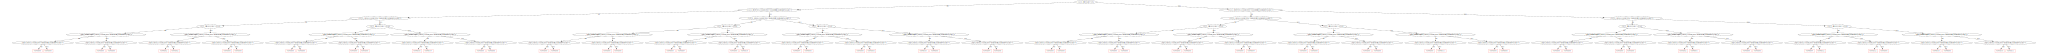

In [120]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


In [121]:
cat_features

['car_0_used_label',
 'car_0_exteriorColor',
 'car_0_interiorColor',
 'car_0_drivetrain',
 'car_0_fuelType',
 'car_0_transmission',
 'car_0_brand',
 'car_1_used_label',
 'car_1_exteriorColor',
 'car_1_interiorColor',
 'car_1_drivetrain',
 'car_1_fuelType',
 'car_1_transmission',
 'car_1_brand',
 'car_2_used_label',
 'car_2_exteriorColor',
 'car_2_interiorColor',
 'car_2_drivetrain',
 'car_2_fuelType',
 'car_2_transmission',
 'car_2_brand',
 'car_3_used_label',
 'car_3_exteriorColor',
 'car_3_interiorColor',
 'car_3_drivetrain',
 'car_3_fuelType',
 'car_3_transmission',
 'car_3_brand',
 'car_4_used_label',
 'car_4_exteriorColor',
 'car_4_interiorColor',
 'car_4_drivetrain',
 'car_4_fuelType',
 'car_4_transmission',
 'car_4_brand',
 'target_used_label',
 'target_exteriorColor',
 'target_interiorColor',
 'target_drivetrain',
 'target_fuelType',
 'target_transmission',
 'target_brand']

In [122]:
[cat_features[index] for index in [list(dataset.columns).index(cat_feature) for cat_feature in cat_features]]

IndexError: list index out of range

In [ ]:
[list(dataset.columns).index(cat_feature) for cat_feature in cat_features]

[0,
 2,
 3,
 4,
 7,
 8,
 10,
 11,
 13,
 14,
 15,
 18,
 19,
 21,
 22,
 24,
 25,
 26,
 29,
 30,
 32,
 33,
 35,
 36,
 37,
 40,
 41,
 43,
 44,
 46,
 47,
 48,
 51,
 52,
 54,
 55,
 57,
 58,
 59,
 62,
 63,
 65]

In [188]:
# Create CatBoost model
model = CatBoostClassifier(iterations=5000, 
                           learning_rate=0.05, 
                           eval_metric='AUC',
                           custom_metric=['Accuracy', 'Precision', 'Recall', 'F1', 'TotalF1'],
                           loss_function='Logloss', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50,
          verbose=10)

# Make predictions on the test data
y_pred = model.predict(X_train)

0:	test: 0.6437570	best: 0.6437570 (0)	total: 3.96ms	remaining: 19.8s
10:	test: 0.7257030	best: 0.7295838 (5)	total: 37.3ms	remaining: 16.9s
20:	test: 0.7205849	best: 0.7295838 (5)	total: 66.1ms	remaining: 15.7s
30:	test: 0.7245219	best: 0.7295838 (5)	total: 96.6ms	remaining: 15.5s
40:	test: 0.7232846	best: 0.7295838 (5)	total: 122ms	remaining: 14.8s
50:	test: 0.7159730	best: 0.7295838 (5)	total: 151ms	remaining: 14.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.729583802
bestIteration = 5

Shrink model to first 6 iterations.


In [ ]:
submission_table = pd.DataFrame(dict(gt = y_train.interaction, pred = y_pred))

In [ ]:
n_correct = 0
for i in range(len(submission_table)):
    current_row = list(submission_table.iloc[i])
    if current_row[0] == current_row[1]:
        n_correct += 1
print(f"test accurracy: {n_correct/len(y_pred)}")

test accurracy: 0.93001443001443


/home/proton/anaconda3/envs/proton/lib/python3.10/site-packages/catboost/core.py:1411: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



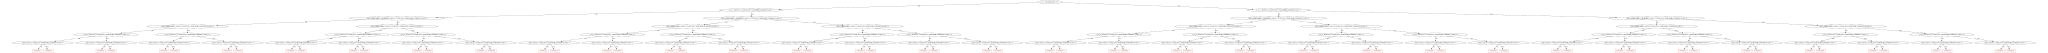

In [ ]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


## Linear Layers Stack

In [125]:
def normalize(x):
    x_normed = x / x.max(0, keepdims=True)[0]
    return x_normed

In [192]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(66, 64) 
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

# Instantiate the neural network
net = BinaryClassification()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Load the dataset

X_test_tensor = normalize(torch.from_numpy(X_val.values))
y_test_tensor = torch.from_numpy(np.array(y_val)).float()

X_train_tensor = normalize(torch.from_numpy(np.array(X_train)))
y_train_tensor = torch.from_numpy(np.array(y_train)).float()

epochs = 40
# Train the neural network
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = torch.sigmoid(net(X_train_tensor))
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_accuracy = accuracy_score(
            y_train_tensor.flatten().int().tolist(), 
            [int(x.item() > 0.6) for x in torch.sigmoid(net(X_train_tensor))]
        )
    
    with torch.no_grad:
        test_accurracy = accuracy_score(
            y_test_tensor.flatten().int().tolist(), 
            [int(x.item() > 0.6) for x in torch.sigmoid(net(X_test_tensor))]
            )
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, epochs, loss.item()))


Epoch [10/40], Loss: 0.6131
Epoch [20/40], Loss: 0.5493
Epoch [30/40], Loss: 0.4844
Epoch [40/40], Loss: 0.4155


In [193]:
from sklearn.metrics import accuracy_score

accuracy_score(
    y_test_tensor.flatten().int().tolist(), 
    [int(x.item() > 0.6) for x in torch.sigmoid(net(X_test_tensor))]
    )

0.6091370558375635